# Автокорректор ошибок на Python

**Вначале немного теории.**

Перед нами стояла следующая задача: изучить алгоритмы, основанных на сравнении слова со списком правильных слов. Запрограммировать эти алгоритмы.

Для алгоритмов сравнения со словарём рекомендую использовать: Расстояние Жаккара и Расстояние Левенштейна.

## 1 Часть. Сравнение расстояний Жаккара и Левенштейна.

Создадим две рекомендательные системы правописания, которые смогут принимать входные данные пользователя и рекомендовать правильно написанное слово, одно при помощи расстояния Жаккара, а другое - Левенштейна.

In [5]:

# Импортируй и властвуй
# %pylab inline
import nltk
from nltk.corpus import words
from nltk.metrics.distance import edit_distance, jaccard_distance
from nltk.util import ngrams
import pandas as pd
import numpy as np

import re
import math
import string
from collections import Counter
import requests

import codecs
with codecs.open('top10000.txt', 'r', encoding = 'utf-8') as file:
    correct_spellings = file.read().replace('\n', ' ') #список правильных слов

correct_spellings = re.findall(r'[а-ё]+', correct_spellings.lower())
#correct_spellings = [w for w in correct_spellings if len(w) > 2]
#correct_spellings[:10]

spellings_series = pd.Series(correct_spellings) # проиндексированный список этих словv


**Метрика: расстояние Жаккара**

Расстояние Жаккара является мерой того, насколько непохожи два набора сдлва, и может быть найдено как дополнение к индексу Жаккара (т. е. расстояние Жаккара = 100% - индекс Жаккара).

Рассматриваемые слова будут итеративно сравниваться с каждым словом в spellings_series.

Spellings создаст список возможных слов на основе первой буквы строки (предполагается, что первая буква напечатана правильно).

Далее, Distances будет итеративно вычислять соответствующие расстояния Жаккара для слов в написании с помощью встроенной функции jaccard_distance.

Наконец, closest даст результирующее слово с лучшим соответствием через функцию min на расстояниях. Затем это слово будет добавлено в список результатов, и этот список будет возвращен после завершения работы функции.



In [6]:
def jaccard(entries, gram_number):
    outcomes = []
    for entry in entries: 
        loopspellings = spellings_series[spellings_series.str.startswith(entry[0])]
        distances = ((jaccard_distance(set(ngrams(entry, gram_number)), set(ngrams(word, gram_number))), word) for word in correct_spellings)
        closest = min(distances)
        outcomes.append(closest[1])
    return outcomes

In [7]:
def JDreco(entries=['чуство']):
 #finds the closest word based on jaccard distance
    return jaccard(entries, 1)

print(JDreco(['чуство']))

['чувство']


**Метрика: расстояние Левенштейна**

Этот метод оценивает, насколько непохожи две строки, на основе минимального количества операций, необходимых для преобразования одной строки в другую.

Функция итеративно сравнивает записи со списком правильных слов и возвращает Расстояние Левенштейна Затем слово с наименьшим расстоянием будет считаться наиболее правильным словом.

In [8]:
def editreco(entries = ['чуство', 'лбить', 'диржат']):
    outcomes = []
    for entry in entries:
        distances = ((edit_distance(entry, word), word) for word in correct_spellings)
        closest = min(distances)
        outcomes.append(closest[1])
        
    return outcomes


print(editreco())

['чувство', 'бить', 'держать']


Теперь дававйте сравним результаты двух работ

In [9]:
userinput = []
word = input()
print(word)
#"Я лублю пильмени"
userinput = re.findall(r'[а-ё]+', word.lower())
print(JDreco(userinput))
print(editreco(userinput))


я лблю бульмени
['я', 'люблю', 'пельмени']
['я', 'люблю', 'пельмени']


In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

In [11]:
import pickle
# читаем сохраненные данные
with open('distance2.data', 'rb') as file:  
    # сохраняем данные как двоичный поток
    data = pickle.load(file)
corpus = data[0]
labels = data[1]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(corpus, labels, test_size = 0.000015, random_state = 42)

In [13]:
length = len(X_test)
correct = 0
for i in range(length):
    if JDreco([X_test[i]])[0] == y_test[i]:
        correct += 1
print(correct / length)

0.6829268292682927


**С помощью метрик *sklearn***:

**Жаккар:**

In [14]:
pred = []
for i in X_test:
    pred.append(JDreco([i])[0])

In [15]:
print(' accuracy:', accuracy_score(y_test, pred))
print('precision:', precision_score(y_test, pred, average = 'macro', zero_division=0))
print('   recall:', recall_score(y_test, pred, average = 'macro', zero_division=0))

 accuracy: 0.6829268292682927
precision: 0.5278969957081545
   recall: 0.5228898426323318


**Левенштейн**:

In [16]:
pred = []
for i in X_test:
    pred.append(editreco([i])[0])

In [18]:
print(' accuracy:', accuracy_score(y_test, pred))
print('precision:', precision_score(y_test, pred, average = 'macro', zero_division=0))
print('   recall:', recall_score(y_test, pred, average = 'macro', zero_division=0))

 accuracy: 0.8682926829268293
precision: 0.7783505154639175
   recall: 0.7912371134020618


----------------------------------------------------------------------------
![Ковальский](https://i.ytimg.com/vi/aare3M4WG5w/hqdefault.jpg " ")

Несмотря на то, что расстояние Жаккара расчитывается быстрее, чем расстояние Дамерау-Левенштейна, все показатели модели, основанной на втором, оказались значительно выше.
Расчет производился на словах, в которых были допущены две ошибки. Подробнее с составлением можно ознакомится в блокноте [s3.ipynb](https://github.com/wequalwo/Alternative_exam/blob/master/s3.ipynb). Словарь - [Топ 10000 слов русского языка](https://github.com/wequalwo/Alternative_exam/blob/master/top10000.txt)

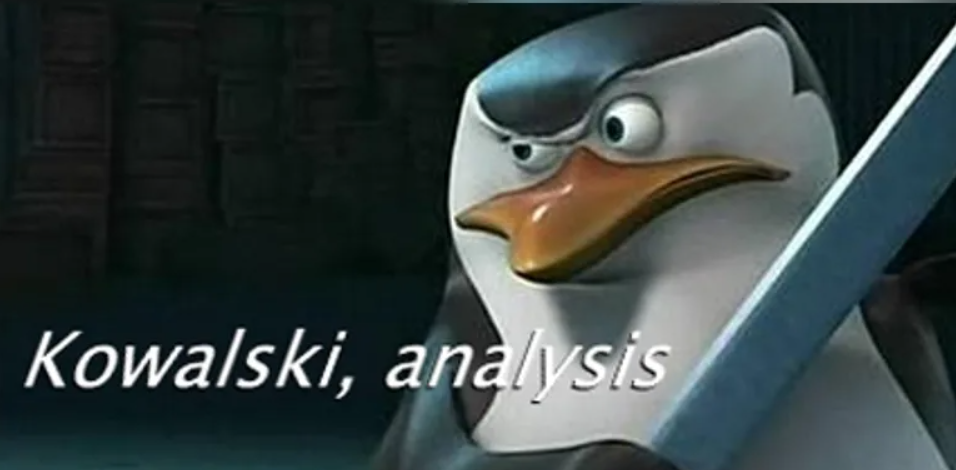

# 2часть. Модель Bag of words

Прежде чем что-то делать со словами, надо эти слова откуда-то взять. Мы сами сделали свой текстовый файл, text.txt, в котором записано много слов из таких произведений как: "Тихий Дон", "Преступление и наказание", "Котлован", "Каштанка", "Капитанская дочка", а также *дополнить*. 


In [91]:
import codecs
with codecs.open('text.txt', 'r', encoding = 'utf-8') as file:
    TEXT = file.read().replace('\n', ' ') # для текста, в котором слова разделены '\n'


In [92]:
with codecs.open('russian.txt', 'r', encoding = 'windows 1251') as file:
    TEXT2 = file.read().replace('\n', ' ') # для текста, в котором слова разделены '\n'\

Добавим в словарь все слова русского языка для того, чтобы модель могла исправить каждое слово, даже то, которое не оказалось в [тексте](https://github.com/wequalwo/Alternative_exam/blob/master/text.txt):

In [93]:
TEXT += TEXT2

Затем нужно этот текст разбить на слова (необходимо выполнить токенизацию). 

In [94]:
def tokens(text):
    #Возвращает список токенов (подряд идущих буквенных последовательностей) в тексте. 
       #Текст при этом приводится к нижнему регистру.
    return re.findall(r'[а-ё]+', text.lower()) 

In [95]:
WORDS = tokens(TEXT)
print('Количество слов в словаре:', len(WORDS))
print( 'Количество неповторяющихся слов в словаре:', len(set(WORDS)))

WORDS2 = tokens(TEXT2)
print(len(WORDS2))

Количество слов в словаре: 1931683
Количество неповторяющихся слов в словаре: 1529351
1535919


Хочу заметить, что сейчас слова появляются в нашем списке в том порядке, как они располагались в файле

***Модель: Мешок слов (aka Bag of Words)***

Мы создали список `WORDS` - список слов в том порядке, как они следуют в `TEXT`. Мы можем использовать этот список в качестве порождающей модели текста. Язык - очень сложная штука и мы создаем крайне упрощенную модель языка, которая может ухватить часть этой сложной структуры. 

В модели мешка слов, мы полностью игнорируем порядок слов, зато соблюдаем их частоту. Представить это можно себе так: вы берете все слова текста и забрасываете их в мешок. Теперь, если вы хотите сгенерировать предложение с помощью этого мешка, вы просто трясете его(слова там перемешиваются) и достаете указанное количество слов по одному (мешок непрозрачный, так что слоа вы достаете наугад). Почти наверное полученное предложение будет грамматически некорректным, но слова в этом предложении будут в +- правильной пропорции (более частые будут встречаться чаще, более редкие - реже). Вот функция, которая сэмплирует предложение из $n$ слов с помощью нашего мешка:

In [24]:
import random
def sample(bag, n=10):
    "Выборка случайного предложения из n слов из модели, описанной мешком слов."
    return ' '.join(random.choice(bag) for _ in range(n))

In [31]:
sample(WORDS)

'пойдемте голенищами смеялась поваре вылущишь брусчатую шатровом дующего криворучко молодила'

Другое представление мешка слов - **`Counter`**. Это словарь, состоящий из пар 

`{'слово': кол-во вхождений слова в текст}`. 

Например:

In [32]:
Counter(tokens('Между нами провода, Города да да да. Я сказал иди сюда, И ты сказала: «Да, да, да..»'))

Counter({'между': 1,
         'нами': 1,
         'провода': 1,
         'города': 1,
         'да': 6,
         'я': 1,
         'сказал': 1,
         'иди': 1,
         'сюда': 1,
         'и': 1,
         'ты': 1,
         'сказала': 1})

Давайте завернем в Counter наш список слов WORDS и посмотрим, что получится:


In [33]:
COUNTS = Counter(WORDS)

print('Десять самых часто встречающихся в тексте слов', COUNTS.most_common(10))

Десять самых часто встречающихся в тексте слов [('и', 14800), ('в', 10407), ('не', 8583), ('на', 6506), ('что', 5203), ('он', 4924), ('с', 4882), ('а', 3690), ('я', 3137), ('его', 2959)]


In [34]:
for w in tokens('самые редкие слова: Крыжить, Михрютка, Драдедамовый '):
    print(w, COUNTS[w])

самые 27
редкие 16
слова 196
крыжить 0
михрютка 1
драдедамовый 3


----------------------------------------------------------------------------
![Джордж Ципф](http://www.factroom.ru/facts/wp-content/uploads/2013/12/224.jpg " ")

В 1935, лингвист Джордж Ципф отметил, что в любом большом тексте $n - $тое наиболее часто встречающееся слово появляется с частотой ~ $ 1/n$ от частоты наиболее часто встречающегося слова. Это наблюдение получило название Закона Ципфа, несмотря на то, что Феликс Ауэрбах заметил это еще в 1913 году. Если нарисовать частоты слов, начиная от самого часто встречающегося, на *log-log*-графике, они должны приблизительно следовать прямой линии, если закон Ципфа верен. 

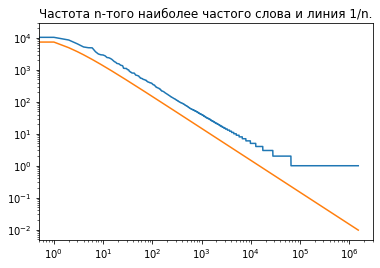

In [37]:
M = COUNTS['и']
import matplotlib.pyplot as plt
plt.yscale('log'); 
plt.xscale('log'); 
plt.title('Частота n-того наиболее частого слова и линия 1/n.')
plt.plot([c for (w, c) in COUNTS.most_common()])
plt.plot([M/i for i in range(1, len(COUNTS)+1)])

Из графика видно, что закон Ципфа выполняется для нашей модели

----------------------------------------------------------------------------
## *Дополнительно:*

Чем плох Bag of words? Тем, что для него $$кошк|у| \neq кошк|а|$$ Как это побороть? А что если мы уберем все окончания и часть суффиксов, одним словом сделаем *стемминг Портера*. Тем самым мы будем считать, что формы слова не являются новыми словами.

Но тогда возникает проблема: существуют слова, для которых стемминг не приведет к одному и тому же слову, например "шел" и "идти". Тогда на помощь приходят морфологические анализаторы, которые приводят слово к начальной форме (лемматизация)

In [38]:
from pymystem3 import Mystem
text = "Красивая мама красиво мыла раму" 
m = Mystem()
lemmas = m.lemmatize(text)
print(''.join(lemmas))

красивый мама красиво мыть рама



In [39]:
import pymystem3
m1=pymystem3.Mystem()

m1.analyze('шел')

[{'analysis': [{'lex': 'идти', 'wt': 1, 'gr': 'V,несов,нп=прош,ед,изъяв,муж'}],
  'text': 'шел'},
 {'text': '\n'}]

Но в таком случае возникает проблема:
"стекло" (существительное или глагол прошедшего времени?), "эти типы стали есть в прокатном цехе" (это про разновидность стали или про голодных людей?)


Морфологические анализаторы иногда делают ошибки и без контекста им не разобраться.
Но *pymystem* вроде как $\pm$ справляется

----------------------------------------------------------------------------

# 3 часть. Проверка Правописания

Применим наивный подход: найдем все кандидаты, достаточно близкие к w и выберем более близкое слово, если проверки на близость недостаточно, берем из подходящих слово с максимальной частотой из WORDS. 

Сейчас мы будем измерять близость с помощью расстояния Левенштейна: минимального необходимого количества удалений, перестановок, вставок, и замен символов, необходимых чтобы одно слово превратить в другое. 

`Расстояние Левенштейна:`

`Исходное слово` $\longrightarrow$ `поиск`

`Вставка` $\longrightarrow$ `происк`

`Удаление` $\longrightarrow$ `п_иск`

`Замена` $\longrightarrow$ `поеск`

Тогда остается определить функцию `correct(w)`:

In [40]:
def correct(word):
    "Поиск лучшего исправления ошибки для данного слова."
    # предрассчитать edit_distance==0, затем 1, затем 2; в противном случае оставить слово "как есть".
    candidates = (known(distance0(word)) or 
                  known(distance1(word)) or 
                  known(distance2(word)) or 
                  [word])
    return max(candidates, key=COUNTS.get)

функция `distance2` легко получается из функции  `distance1`:


In [41]:
#Вернуть подмножество слов, которое есть в нашем словаре.
def known(words):
    return {w for w in words if w in COUNTS}


#"Вернуть все строки, которые находятся на edit_distance == 0  (т.е., просто само слово)
def distance0(word):
    return {word}

#Вернуть все строки, которые находятся на edit_distance == 2
def distance2(word):
    return {e2 for e1 in distance1(word) for e2 in distance1(e1)}

Функция `distance1` должна возвращать множество слов, находящихся на расстоянии `edit_distance == 1`. Например для слова "киты" это множество будет включать слова "коты" (замена и на o) и слово "ккиты" (вставка к),  а также "икты" (перемена к и и местами); после чего может быть применена функция known для фильтрации и выбора подходящих кандидатов). 
Как же нам получить их? Например можно разбить исходное слово на пару всеми возможными способами (каждое разбиение даст нам пару "слов"), (a, b), первая часть - до места разбиения, а вторая - после, и в каждом месте разбиения можно: удалить, поменять местами, заменить или вставить букву:

In [42]:
def distance1(word):
    "Возвращает список всех строк на расстоянии edit_distance == 1 от word."
    pairs      = splits(word)
    deletes    = [a+b[1:]           for (a, b) in pairs if b]
    transposes = [a+b[1]+b[0]+b[2:] for (a, b) in pairs if len(b) > 1]
    replaces   = [a+c+b[1:]         for (a, b) in pairs for c in alphabet if b]
    inserts    = [a+c+b             for (a, b) in pairs for c in alphabet]
    return set(deletes + transposes + replaces + inserts)

def splits(word):
    "Возвращает список всех возможных разбиений слова на пару (a, b)."
    return [(word[:i], word[i:]) 
            for i in range(len(word)+1)]

alphabet = 'абвгдеёжзийклмнопрстуфхцчшщъыьяюя'

In [43]:
print("Мощность алфавита:", len(alphabet))

Мощность алфавита: 33


In [44]:
print(distance0('атец'))
print(distance1('атец'))
print(len(distance2('атец')))

{'атец'}
{'атиец', 'агец', 'атефц', 'афец', 'чтец', 'датец', 'атев', 'атег', 'ратец', 'аптец', 'аутец', 'атгец', 'атхц', 'атуец', 'атчц', 'ьтец', 'фатец', 'мтец', 'атеё', 'атнец', 'атц', 'аоец', 'жтец', 'аыец', 'атеь', 'астец', 'атецч', 'аюец', 'атсц', 'атем', 'атрец', 'аътец', 'атет', 'алтец', 'агтец', 'йатец', 'апец', 'аттц', 'атщц', 'атецж', 'атецш', 'затец', 'атюец', 'ъатец', 'атзец', 'ттец', 'атее', 'атеб', 'атен', 'атеёц', 'атпц', 'аьтец', 'аетец', 'атеж', 'аиец', 'аотец', 'атеца', 'атецё', 'аткец', 'атьец', 'атшц', 'ютец', 'атецб', 'атецг', 'афтец', 'еатец', 'атежц', 'ктец', 'атерц', 'атеоц', 'атемц', 'атец', 'атпец', 'атеиц', 'атеъц', 'цтец', 'атуц', 'атес', 'атецт', 'атьц', 'атнц', 'аытец', 'атецд', 'амец', 'щатец', 'атеф', 'бтец', 'аштец', 'хтец', 'атце', 'атецо', 'атйц', 'ьатец', 'ааец', 'ашец', 'катец', 'азтец', 'атецс', 'атлц', 'тец', 'ател', 'аитец', 'актец', 'атвец', 'атъец', 'атжц', 'аетц', 'атезц', 'атецз', 'отец', 'атйец', 'цатец', 'атбц', 'лтец', 'атея', 'аётец', 'ат

In [45]:
print(tokens('Ана ни зочит в шшколу.'))
print(list(map(correct, tokens('Ана ни зочит в шшколу.'))))

['ана', 'ни', 'зочит', 'в', 'шшколу']
['ана', 'ни', 'точит', 'в', 'школу']


Выходные данные можно сделать покрасивее, сохранив регистр

In [46]:
def correct_text(text):
    "Исправить все слова с опечатками в тексте."
    return re.sub('[а-ёА-Ё]+', correct_match, text)

def correct_match(match):
    "Исправить слово word в match-группе, сохранив регистр: upper/lower/title."
    word = match.group()
    return case_of(word)(correct(word.lower()))

def case_of(text):
    "Возвращает функцию регистра по тексту: upper, lower, title, или str."
    return (str.upper if text.isupper() else
            str.lower if text.islower() else
            str.title if text.istitle() else
            str)

***Насколько дорого превращать одно слово в другое?***

Динамическое программирование позволяет разбить задачу на подзадачи, решив которые можно скомпоновать финальное решение. Мы будем пытаться превратить строку `source[0..i]` в строку `target[0..j]`, мы сосчитаем все возможные комбинации подстрок `substrings[i, j]` и рассчитаем их `edit_distance` до нашей исходной. Мы будем сохранять результаты в таблицу и переиспользовать их для расчета дальнейших изменений.


In [47]:
def min_edit_distance(source, target, ins_cost = 1, del_cost = 1, rep_cost = 2):
    '''
    Input: 
        source: строка-исходник
        target: строка, в которую мы должны исходник превратить
        ins_cost: цена вставки
        del_cost: цена удаления
        rep_cost: цена замены буквы
    Output:
        D: матрица размера len(source)+1 на len(target)+1 содержащая минимальные расстояния edit_distance
        med: минимальное расстояние edit_distance (med), необходимое, 
        чтобы превратить строку source в строку target
    '''
    # стоимость удаления и вставки = 1
    m = len(source)
    n = len(target)

    # Заткнем нашу матрицу нулями
    D = np.zeros((m+1, n+1), dtype=int) 
    
    # Заполним первую колонку
    for row in range(1,m+1): 
        D[row,0] = D[row-1,0] + del_cost
        
    # Заполним первую строку
    for col in range(1,n+1): 
        D[0,col] = D[0,col-1] + ins_cost
        
    # Теперь пойдем от 1 к m-той строке
    for row in range(1,m+1): 
        
        # итерируемся по колонкам от 1 до n
        for col in range(1,n+1):
            
            # r_cost - стоимость замены
            r_cost = rep_cost
            
            # Совпадает ли буква исходного слова из предыдущей строки
            # с буквой целевого слова из предыдущей колонки, 
            if source[row-1] == target[col-1]:
                # Если они не нужны, то замена не нужна -> стоимость = 0
                r_cost = 0
                
            # Обновляем значение ячейки на базе предыдущих значений 
            # Считаем D[i,j] как минимум из трех возможных стоимостей (как в формуле выше)
            D[row,col] = min([D[row-1,col]+del_cost, D[row,col-1]+ins_cost, D[row-1,col-1]+r_cost])
          
    # установить edit_distance в значение из правого нижнего угла
    med = D[m,n]
    

    return D, med

In [48]:
source =  'кроты'
target = 'киты'
matrix, min_edits = min_edit_distance(source, target)

print("Расстояние: ",min_edits, "\n")

idx = list('#' + source)
cols = list('#' + target)
df = pd.DataFrame(matrix, index=idx, columns= cols)
print(df)

Расстояние:  3 

   #  к  и  т  ы
#  0  1  2  3  4
к  1  0  1  2  3
р  2  1  2  3  4
о  3  2  3  4  5
т  4  3  4  3  4
ы  5  4  5  4  3


## 4 часть. От счетчика слов к вероятностям последовательностей слов. Разбиение на сегменты

Нам нужно научиться подсчитывать вероятности слов, $P(w)$. Делать мы это будем с помощью функции `pdist`, которая на вход принимает *Counter* (мешок слов) и возвращает функцию, выполняющую роль вероятностного распределения на множестве всех возможных слов.

In [49]:
#Превращает частоты из Counter в вероятностное распределение
def pdist(counter):
    N = sum(list(counter.values()))
    return lambda x: counter[x]/N

P = pdist(COUNTS)

In [50]:
for w in tokens('То мать пирогов напечет, то бабушка с булочками приедет'):
    print(P(w), w)

0.0014157824281471007 то
8.80011015667302e-05 мать
2.5882676931391233e-06 пирогов
5.176535386278247e-07 напечет
0.0014157824281471007 то
4.1412283090225975e-06 бабушка
0.0025271845755810403 с
5.176535386278247e-07 булочками
5.694188924906072e-06 приедет


Что такое вероятность последовательности слов? 
Используем определение совместной вероятности:
$$P(w_1 ... w_n) = P(w_1) \cdot P(w_2|w_1) \cdot P(w_3|w_1w_2) \cdot ... \cdot P(w_n|w_1...w_n-1)$$
Модель мешка слов подразумевает, что каждое слово из мешка достается независимо от других. Это дает нам упрощенную аппроксимацию:
$$P(w_1 ... w_n) = P(w_1) \cdot P(w_2) \cdot P(w_3) \cdot ... \cdot P(w_n)$$

*Известный статистик Джордж Бокс сказал Все модели неверны, но некоторые полезны*

Как же нам посчитать $P(w_1 ... w_n)$? Мы будем использовать другое название `Pwords` вместо `P`, и посчитаем ее как произведение индивидуальных вероятностей:

In [51]:
#Вероятности слов, при условии, что они независимы
def Pwords(words):
    return product(P(w) for w in words)

#Перемножим числа
def product(nums):
    result = 1
    for x in nums:
        result *= x
    return result

In [52]:
tests = ['тест', 
         'дом',
         'Крыжить']

for test in tests:
    print(Pwords(tokens(test)), test)

5.176535386278247e-07 тест
6.677730648298939e-05 дом
0.0 Крыжить


кажется, присвоить последнюю вероятность 0, неправильно; Она просто должна быть маленькой. К этому вернемся попозже. Ну а другие вероятности кажутся  адекватными.

## Разбиение слов на сегменты
Исправляем ошибки, когда слова пишутся слитно (по ошибке или нет)


**Подход 1:** Перенумеруем все возможные разбиения и выберем то, у которого максимальная Pwords

Вопрос: Как выбрать количество сегментов для строки длины n?

**Подход 2:** Делаем одно разбиение - на первое слово и все остальное. Если предположить, что слова независимы, можно максимизировать вероятность первого слова + лучшего разбиения оставшихся букв.


`assert segment('фотоальбом') == ['фото', 'альбом']
segment('фотоальбом') ==
   max(Pwords(['ф'] + segment('отоальбом')),
       Pwords(['фо'] + segment('тоальбом')),
       Pwords(['фот'] + segment('оальбом')),
       Pwords(['фото'] + segment('альбом')),
       ...
       Pwords(['фотоальбом'] + segment('')))`

Чтобы сделать это эффективным, нужно избежать слишком большого числа пересчетов оставшейся части слова. Это можно сделать c помощью кэширования. Кроме того, для первого слова не обязательно брать все возможные варианты разбиений - мы можем установить максимальную длину. Какой она должна быть? Чуть большей, чем длина самого длинного слова, которое мы видели.

In [96]:
#Запомнить результаты исполнения функции f, чьи аргументы args должны быть хешируемыми.
def memo(f):
    cache = {}
    def fmemo(*args):
        if args not in cache:
            cache[args] = f(*args)
        return cache[args]
    fmemo.cache = cache
    return fmemo

In [97]:
max(len(w) for w in COUNTS)

34

In [98]:
#Вернуть список всех пар (a, b); start <= len(a) <= L
def splits(text, start=0, L=20):
    return [(text[:i], text[i:]) 
            for i in range(start, min(len(text), L)+1)]

In [99]:
print(splits('слово'))
print(splits('длинныйтекст', 3, 7))

[('', 'слово'), ('с', 'лово'), ('сл', 'ово'), ('сло', 'во'), ('слов', 'о'), ('слово', '')]
[('дли', 'нныйтекст'), ('длин', 'ныйтекст'), ('длинн', 'ыйтекст'), ('длинны', 'йтекст'), ('длинный', 'текст')]


In [100]:
#Вернуть список слов, который является наиболее вероятной сегментацией нашего текста
@memo
def segment(text):
    if not text: 
        return []
    else:
        candidates = ([first] + segment(rest) 
                      for (first, rest) in splits(text, 1))
        res = max(candidates, key=Pwords)
        for i in res:
            if i not in WORDS:
                return [text]
        return res

In [101]:
segment('сдырочкойвправомбоку')

['с', 'дырочкой', 'в', 'правом', 'боку']

In [102]:
decl = ('предложениеэтосложнаясинтаксическаяконструкция')

In [103]:
print(segment(decl))

['предложение', 'это', 'сложная', 'синтаксическая', 'конструкция']


In [104]:
segment('смья')

['смья']

Данный метод лействительно хорошо решает проблему слипания слов.
Важно то, что слова, которые "слиплись", должны находиться в словаре. Иначе возникают трудности. Поэтому словарь, на котором работает модель, состоит из [большого текста](https://github.com/wequalwo/Alternative_exam/blob/master/text.txt) и добаленного к нему [полного списка слов русского языка во всех формах](https://github.com/danakt/russian-words)

**Анализ Биграммной модели:  вроде бы лучше, но не очень.**

## 5 часть. Валидация

До настоящего момента мы пытались интуитивно оценить результаты нашей работы. Тем не менее, никаких численных оценок качества мы пока не получили. Важно понимать, что без четких метрик слова "плохо"/"хорошо" не имеют никакого смысла. Более того - мы даже не можем четко ответить, было ли наше обновление модели в лучшую сторону или худшую. 

Обычно при построении неких прогностических моделей данные разбиваются на три части:

* **Обучающая выборка:** то, что мы использовали для создания модели исправления ошибок; У нас это был файл text.txt.
* **Тестовая выборка:** набор данных, который можно использовать для оценки качества вашей модели по ходу разработки.
* **Валидационная выборка:** Набор данных, который мы используем для оценки работы программы после того как программа готова. Тестовая выборка для этого быть использована не может. 

Для нашей программы обучающая выборка - словарь слов с частотами, а тестовая выборка - набор примеров типа "фотоальбом". 

Сделаем валидационную выборку.

In [74]:
def test_segmenter(segmenter, tests):
    "Оценка сегментатора на тестовых данных; вывести на печать ошибки; вернуть долю верно разбитого."
    return sum([test_one_segment(segmenter, test) 
               for test in tests]), len(tests)

def test_one_segment(segmenter, test):
    words = tokens(test)
    result = segmenter(''.join(words))
    correct = (result == words)
    if not correct:
        print('expected', words)
        print('got     ', result) 
    return correct

proverbs = ("""Унас под крыльцом живут ежи. По вечерам вся смья выходит гулять.""".splitlines())


In [106]:
test_segmenter(segment, proverbs)

expected ['унас', 'под', 'крыльцом', 'живут', 'ежи', 'по', 'вечерам', 'вся', 'смья', 'выходит', 'гулять']
got      ['унасподкрыльцомживутежиповечерамвсясмьявыходитгулять']


(0, 1)

## 7часть. Сглаживание

Проблема в том, что если в последовательности вероятность одного из слов - 0, то вся вероятность бы обнулилась (мы же считаем произведение). Кажется, что это слишком строгое условие; Словарь не идеален и точно существуют реальные слова, которых мы не увидели. Давайте не будем все сразу обнулять. 
Например точно должна быть оценка вероятности того, что слово настоящее. Скажем, "сверхзвуковой" явно должно быть более вероятным чем "рыбркле" и должно иметь бОльшую вероятность.

Проблему можно побороть, присвоив таким "не встретившимся" словам ненулевую вероятность. Еще более важным этот пункт становится при переходе к токенам из нескольких слов (биграммам, например), потому что чем больше слов в токене, тем больше вероятность, что какой-то реальный токен в нашей обучающей выборке отсутствует.

Нашу модель можно представить в виде забора вероятностей, где столбик равен вероятности слова/токена, которое/который в выборке было/был, и равен 0, если слова/токена в выборке не было; Мы хотим сгладить наше распределение вокруг этих пиков, чтобы модель давала какой-то ответ вне зависимости от наличия или отсутствия слова в корпусе. Этот процесс и называется сглаживанием.

**Место для анекдота про Лапласа**

Однажды французского математика Лапласа спросили: "Какова вероятность того, что Солнце завтра взойдет?". Из данных, что оно из  ближайших дней взошло n раз следует оценка максимального правдоподобия $n/n = 1$. Но Лапласу хотелось чуть сбалансировать оценку на шанс того, что завтра Солнце может и не взойти, поэтому он дал оценку $(n+1)/(n+2)$.

То, что мы знаем, ограничено, а то, чего мы не знаем,-бесконечно
— Пьер Симон Лаплас, 1749-1827

In [ ]:
def pdist_additive_smoothed(counter, c=1):
    """Вероятность слова, при условии данных из Counter'a.
    добавляем c к частоте каждого слова + слово 'unknown'."""
    N = sum(list(counter.values()))          # суммарное кол-во слов
    Nplus = N + c * (len(counter) + 1) # кол-во слов + сглаживание
    return lambda word: (counter[word] + c) / Nplus 

P1w = pdist_additive_smoothed(COUNTS1)

In [ ]:
P1w('сверхзвуковой')

Теперь еще одна проблема ... у нас появились незнакомые слова с ненулевой вероятностью. А что если 10-12 - приемлемая вероятность для слов нашего текста: то есть, если я читаю новый текст, вероятность того, что следующее слово мне незнакомо, может быть порядка 10-12. Но если я случайно генерирую 20-буквенный последовательности, вероятность того, что одна из них будет реальным словом намного меньше чем 10-12.

У нас две проблемы:

* Во-первых, у нас нет четкой модели для неизвестных слов. Мы говорим "неизвестное слово", но не различаем более вероятные неизвестные слова и менее вероятные неизвестные слова. Ну, например, вероятнее ли 8-буквенное неизвестное слово чем 20-буквенное неизвестное слово?

* Во-вторых, мы не берем в расчет информацию из частей неизвестных слов. Например, "сверхзвуковой" явно должно быть более вероятным чем "рыбркле".

Для нашего следующего подхода мы используем идеи метода Гуда - Тьюринга. Он оценивает вероятности слов, не встретившихся в нашем Counter'е, на основании вероятностей слов, встретившихся единожды (Можно туда же подключить вероятности для встретившихся 2 раза и т.д.).

Итак, сколько слов встретилось 1 раз в COUNTS? (В COUNTS1 ни одного такого слова нет.) И какие длины у этих слов? Давайте посмотрим:


In [ ]:
singletons = (w for w in COUNTS if COUNTS[w] == 1)
lengths = list(map(len, singletons))
Counter(lengths).most_common()

In [ ]:
matplotlib.pyplot.hist(lengths, bins=len(set(lengths)))

**Анализ:** Длины таких слов распределены похоже на нормальное распределение :)

In [ ]:
def pdist_good_turing_hack(counter, onecounter, base=1/33., prior=1e-8):
    """Вероятность слова при условии данных из счетчика.
    Для неизвестных слов, смотрим на слова, встретившиеся единожды из onecounter, 
    вероятность выбираем, основываясь на длине.
    Воспользуемся идеей метода Гуда-Тьюринга(полностью мы его здесь не реализуем).
    prior -добавочный фактор, который сделает неизвестные слова менее вероятными.
    base -то, насколько мы уменьшаем вероятность за длину слова больше максимального."""
    N = sum(list(counter.values()))
    N2 = sum(list(onecounter.values()))
    lengths = list(map(len, [w for w in onecounter if onecounter[w] == 1]))
    ones = Counter(lengths)
    longest = max(ones)
    return (lambda word: 
            counter[word] / N if (word in counter) 
            else prior * (ones[len(word)] / N2 or 
                          ones[longest] / N2 * base ** (len(word)-longest)))
#Переопределим P1w
P1w = pdist_good_turing_hack(COUNTS1, COUNTS)

In [ ]:
segment.cache.clear()


# THE END

У Норвига в статье код занимает 21 строчку: 


In [ ]:
import re, collections
def words(text):
    return re.findall('[а-ё]+', text.lower())
def train(features):
    model = collections.defaultdict(lambda: 1)
    for f in features:
        model[f] += 1
    return model
    
with codecs.open('words.txt', 'r', encoding = 'windows 1251') as file:
    TEXT = file.read().replace('\n', ' ')

NWORDS = train(words(TEXT))
alphabet = 'абвгдеёжзийклмнопрстуфхцчшщъыьэюя'
def distance1(word):
    n = len(word)
    return set( [word[0:i]+word[i+1:] for i in range(n)] +                      # deletion
                [word[0:i]+word[i+1]+word[i]+word[i+2:] for i in range(n-1)] +   # transposition
                [word[0:i]+c+word[i+1:] for i in range(n) for c in alphabet] +    # alteration
                [word[0:i]+c+word[i:] for i in range(n+1) for c in alphabet])    # insertion
def known_distance2(word):
    return set(e2 for e1 in distance1(word) for e2 in distance1(e1) if e2 in NWORDS)
def known(words): return set(w for w in words if w in NWORDS)
def correct(word):
    candidates = known([word]) or known(distance1(word)) or known_distance2(word) or [word]
    return max(candidates, key=lambda w: NWORDS[w])

Использовать этот код нужно следующим образом –



In [ ]:
to_correct = tokens('Саничка не хочит в шшклу')

for word in to_correct:
    print(correct(word), end = ' ') 

Пусть дано слово, будем пытаться отыскать слово, в котором с наибольшей вероятностью исправлены допущенные ошибки (если ошибок нет, то таким словом будет данное). Разумеется, мы не сможем гарантировать 100% исправления всех ошибок. (Например, если нам дано слово «пак», то правильным будет слово «паз» или «парк» ?), именно поэтому мы используем вероятностный (или другими словами стохастический) подход. 
Будем говорить, что мы пытаемся выбрать такое слово c из всех возможных слов-исправлений, что вероятность появления именно слова c при данном слове w будет максимальна:

`argmaxc P(c|w)`


Согласно теореме Байеса - выражение, записанное выше, эквивалентно следующему выражению:

`argmaxc P(w|c) P(c) / P(w)`

Поскольку P(w) одинакова для всех c мы можем отбросить P(w), что даст нам:

`argmaxc P(w|c) P(c)`

--------------------------------------------------------------------------------------
В этом выражении присутствуют три части.  
Справа налево:

***P(c)*** – вероятность появления слова c (частотность употребления c). Эта вероятность обусловлена самим языком (точнее моделью языка). Иначе говоря, P(c) определяет как часто c встречается в текстах на русском языке. P(«превед») будет достаточно высока, тогда как P(«благоденствовать») будет меньше, а P(«ыгввыцшы») будет около нуля.

***P(w|c)*** – вероятность того, что автор опечатался и написал w, хотя имел в виду c. По сути дела эта вероятность обусловлена частотностью тех или иных ошибок в языке (и называется моделью ошибок языка).

***argmaxc*** – оператор, перебирающий все возможные c в поиске наиболее (вероятнее всего) подходящего из них (т.е. данный оператор ищет такое допустимое c, которе максимизирует условную вероятность появления w при данном c).

Может возникнуть очевидный вопрос – зачем мы преобразовали простое выражение «argmaxc P(c|w)» с помощью какого-то Байеса в более сложное выражение, в котором используются аж две языковые модели, вместо одной? Дело в том, что P(c|w) учитывает в себе сразу обе языковых модели, поэтому очевидно, что проще выделить эти модели и работать с ними по отдельности. Предположим у нас есть слово с опечаткой – «езать», это может быть как «ехать», так и «резать». Для какого из исправлений P(c|w) будет максимально ? Оба исправления имеют примерно одинаковую частотность в русском языке. Хорошо допустим «х» и «з» близко расположены в русской раскладке клавиатуры и это повышает вероятность варианта «ехать», но это не повод, чтоб отбрасывать «резать», ведь «е» и «р» тоже близки. Поэтому лучше не рассматривать P(c|w) как единую величину, ибо нам приходится учитывать и частность исправления c и вероятность исправления c для данной опечатки в w. Удобнее работать с этими двумя вероятностями по отдельности.

----------------------------------------------------------------------------------------------

нужно продолжить описание 

## На "подумать" (не доделано)

---------------------------------------------------------------------------
Можно перейти к анализу пар последоваительных слов, не ожидая, что вероятности слишком часто будут обнуляться (представьте себе, сколько в языке может быть грамматически корректных сочетаний из двух слов).


In [71]:
def load_counts(text, sep='\t'):
    """Возвращает Counter, полученный из пар ключ-значение,в каждой строке файла."""
    C = Counter()
    for i in [l.split('\t') for l in text.split('\n')][:-1]:
        key, count = i
        C[key] = int(count)
    return C
COUNTS1 = COUNTS #слова и их часатота
COUNTS2 = COUNTS #TODO: словосочетания и их частота

P1w = pdist(COUNTS1)
P2w = pdist(COUNTS2)
print(len(COUNTS1), sum(list(COUNTS1.values()))/1e9)
print(len(COUNTS2), sum(list(COUNTS2.values()))/1e9)
COUNTS2.most_common(30)

1529375 0.001931794
1529375 0.001931794


[('и', 14800),
 ('в', 10407),
 ('не', 8583),
 ('на', 6506),
 ('что', 5203),
 ('он', 4924),
 ('с', 4882),
 ('а', 3690),
 ('я', 3137),
 ('его', 2959),
 ('как', 2913),
 ('то', 2735),
 ('к', 2426),
 ('но', 2394),
 ('по', 2275),
 ('это', 2135),
 ('за', 1946),
 ('она', 1798),
 ('у', 1729),
 ('из', 1590),
 ('все', 1568),
 ('же', 1539),
 ('так', 1449),
 ('ее', 1385),
 ('от', 1371),
 ('ты', 1335),
 ('о', 1125),
 ('было', 1114),
 ('только', 1106),
 ('ему', 1104)]

**Сегментация с помощью биграмм**

Чуть менее неправильная аппроксимация:
$$P(w_1...w_n)=P(w_1) \cdot P(w_2|w_1) \cdot P(w_3|w_2) \cdot ...  \cdot P(w_n|w_n-1)$$
Эта штука называется биграммной моделью. Представьте, что вы взяли текст, достали из него все возможные пары подряд идущих слов и положили каждую пару в мешок, промаркированный ПЕРВЫМ словом из пары. После этого, чтобы сгенерировать кусок текста, мы берем первое слово из исходного мешка слов , а каждое следующее слово вынимаем из соответствующего мешка биграмм.

Начнем с определения вероятности текущего слова при условии данного предыдущего слова из Counter:

Отмечу, что для английского языка биграммная модель будет выглядеть так:
$$P(w_1...w_n)=P(w_1) \cdot P(w_2|w_1) \cdot P(w_3|w_2) \cdot ... \cdot P(w_n|w_n-1)$$
условная вероятность слова при условии предыдущего слова определяется так:
$$P(w_n|w_n-1)=\frac{P(w_n-1w_n)}{P(w_n-1)}$$



In [72]:
def Pwords2(words, prev='<S>'):
    "Вероятность последовательности слов с помощью биграммной модели(при условии предыдущего слова)."
    return product(cPword(w, (prev if (i == 0) else words[i-1]) )
                   for (i, w) in enumerate(words))

# Перепишем Pwords на большой словарь P1w вместо Pword
def Pwords(words):
    "Вероятности слов при условии их независимости."
    return product(P1w(w) for w in words)

def cPword(word, prev):
    "Условная вероятность слова при условии предыдущего."
    bigram = prev + ' ' + word
    if P2w(bigram) > 0 and P1w(prev) > 0:
        return P2w(bigram) / P1w(prev)
    else: # если что-то не встретилось, поставим среднее между P1w и 0
        return P1w(word) / 2
print(Pwords(tokens('Он приехал в город')))
print(Pwords2(tokens('Приехал он в город')))
print(Pwords2(tokens('Город в он приехал')))



9.60375018944572e-15
6.002343868403575e-16
6.002343868403575e-16


Чтобы сделать `segment2`, скопируем `segment`, добавим в аргументы предыдущий токен, а вероятности будем считать с помощью `Pwords2` вместо `Pwords` 


In [73]:
@memo
def segment2(text, prev='<S>'): 
    "Возвращает наилучшее разбиение текста, используя статистику биграмм." 
    if not text: 
        return []
    else:
        candidates = ([first] + segment2(rest, first) 
                      for (first, rest) in splits(text, 1))
        return max(candidates, key=lambda words: Pwords2(words, prev))

print(segment2('фотоальбом'))
print(segment2('поехалаонанет'))

['фотоальбом']
['поехала', 'она', 'нет']
